# Plotting of Potential Vorticity and PV Cross-sections 

This notebook is an example of plotting PV

In [ ]:
import numpy as np

from herbie import Herbie

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy.calc as mpcalc
from metpy.units import units
import metpy
import numpy as np
import xarray as xr

from metpy.interpolate import cross_section

## Set Date and Model to Be Analyzed

In [15]:
year = 2021
month = 12
day = 15
hour = 18
forecast_hour = 3

model = 'gfs'


In [16]:
date_str = f"{year}-{month:02d}-{day:02d} {hour:02d}:00"
print(f"Grabbing Data for {date_str}")
print('\n')
H = Herbie(
    date_str,
    model = model,
    fxx = forecast_hour)
print('\n')
#set data subset:
subset = r":(?:HGT|TMP|UGRD|VGRD):\d+ mb:"
print('Downloading Data.  This may take a while...')
ds = H.xarray(subset)
print("\nFile Downloaded.")


Grabbing Data for 2021-12-15 18:00


✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2021-Dec-15 18:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws


👨🏻‍🏭 Created directory: [/home/jared.marquis/data/gfs/20211215]

File Downloaded.


In [17]:
#subset the data to just North America
lon_slice = slice(200,350)
lat_slice = slice(85,10)

lats = ds.latitude.sel(latitude=lat_slice).values
lons = ds.longitude.sel(longitude=lon_slice).values

pres = ds.isobaricInhPa.values[:] * units('hPa')

tmpk = ds['t'].metpy.sel(latitude=lat_slice,longitude=lon_slice).squeeze()
uwnd = ds['u'].metpy.sel(latitude=lat_slice,longitude=lon_slice).squeeze() #* units('m/s')
vwnd = ds['v'].metpy.sel(latitude=lat_slice,longitude=lon_slice).squeeze() #* units('m/s')
hght = ds['gh'].metpy.sel(latitude=lat_slice,longitude=lon_slice).squeeze() #* units('m')

#calculate potential temperature
thta = mpcalc.potential_temperature(pres[:,None,None],tmpk)
vtime = ds.valid_time.data.astype('datetime64[ms]').astype('O')

In [30]:
#smooth data
uwnd_s = mpcalc.smooth_n_point(uwnd, 9, 2)
vwnd_s = mpcalc.smooth_n_point(vwnd, 9, 2)
tmpk_s = mpcalc.smooth_n_point(tmpk, 9, 2)
hght_s = mpcalc.smooth_n_point(hght, 9, 2)
wspd_s = mpcalc.smooth_n_point(np.sqrt(uwnd**2+vwnd**2), 9, 2)*units('m/s')
thta_s = mpcalc.potential_temperature(pres[:,None,None],tmpk_s)

In [33]:
#calculate baroclinic potential vorticiyt on all isobaric levels
# Compute dx and dy spacing for use in vorticity calculation
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Comput the PV on all isobaric surfaces
pv = mpcalc.potential_vorticity_baroclinic(thta_s, pres[:, None, None], uwnd_s, vwnd_s,
                                           dx[None, :, :], dy[None, :, :],
                                           lats[None, :, None] * units('degrees'))


# Find the index value for the 250-hPa surface
i250 = list(pres.m).index(((250 * units('hPa')).to(pres.units)).m)
i300 = list(pres.m).index(((300 * units('hPa')).to(pres.units)).m)
i500 = list(pres.m).index(((500 * units('hPa')).to(pres.units)).m)

NameError: name 'cmap' is not defined

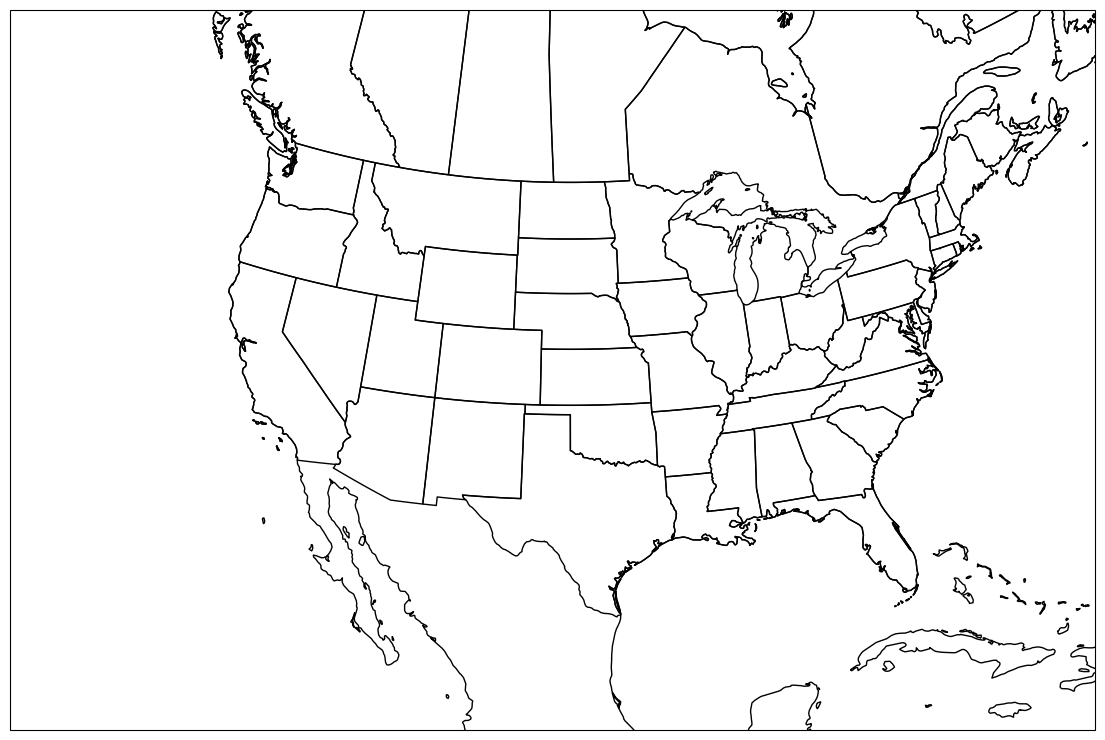

In [34]:
#plot geopotential height and winds
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

# Plot the contours of wind speed at 500 hPa
colors = [(0.000, '#FFFFFF'),
          (0.083, '#87CEFA'),
          (0.166, '#6A5ACD'),
          (0.250, '#E696DC'),
          (0.333, '#C85ABE'),
          (0.416, '#A01496'),
          (0.500, '#C80028'),
          (0.583, '#DC283C'),
          (0.666, '#F05050'),
          (0.750, '#FAF064'),
          (0.833, '#DCBE46'),
          (0.916, '#BE8C28'),
          (1.000, '#A05A0A')]
ct = ax.contourf(lons,lats,
                 wspd_s[i300].metpy.convert_units('kts').values,
                 np.arange(50,171,1),cmap=cmap,transform=ccrs.PlateCarree())
cbar = fig.colorbar(ct,location="bottom",ticks=np.arange(50,171,10),pad=0.01)
cbar.set_label('WIND SPEED (knots)')

# Plot the geopotential heights
clevs_500_hght = np.arange(0, 18000, 60)
cs = ax.contour(lons, lats, hght_s[i300], clevs_500_hght, colors='black',
                transform=datacrs)
ax.clabel(cs,inline=True,fmt=lambda v: format(v/10,'.0f')[:3],zorder=10)

# Plot the wind barbs at 500 hPa
wind_slice = slice(None, None, 15)
ax.barbs(lons[wind_slice], lats[wind_slice],
         uwnd_s[i300][wind_slice, wind_slice].metpy.convert_units('kts').values,
         vwnd_s[i300][wind_slice, wind_slice].metpy.convert_units('kts').values, pivot='middle',
         color='black', length=6.5, transform=datacrs)

# Plot some titles to tell people what is on the map
plt.title('300-hPa GFS PV (PVU), 300-hPa Geopotential Height (dam),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

fig.savefig('GFS_wind_300.png',bbox_inches='tight')

In [ ]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

# Plot the contours of PV at 500 hPa, scaling 10^6 every 1 PVU
clevs_pv = np.append(np.arange(-1.4, 2, 0.2),np.arange(2,9.2,0.4))
cmap = mcolors.LinearSegmentedColormap.from_list("",
                        ["blue","lightblue","lightblue","yellow","orange","red","darkred"])
cs1 = ax.contourf(lons, lats, pv[i300]*1e6, clevs_pv, cmap=cmap,
                 transform=datacrs,extend='both')
cbar = plt.colorbar(cs1,orientation='horizontal',extend=True,pad=0.01,
             label=r'Potential Vorticity Units (PVU; $\rm{10^{-6}\ K\ kg^{-1}\ m^{2}\ s^{-1}})$')

cs1 = ax.contour(lons, lats, pv[i300]*1e6, [2], colors='magenta',linestyles='dashed',linewidths=3,
                 transform=datacrs)

# Plot the geopotential heights
clevs_500_hght = np.arange(0, 18000, 60)
cs = ax.contour(lons, lats, hght_s[i300], clevs_500_hght, colors='black',
                transform=datacrs)
ax.clabel(cs,inline=True,fmt=lambda v: format(v/10,'.0f')[:3],zorder=10)

# Plot the wind barbs at 500 hPa
wind_slice = slice(None, None, 15)
ax.barbs(lons[wind_slice], lats[wind_slice],
         uwnd_s[i300][wind_slice, wind_slice].metpy.convert_units('kts').values,
         vwnd_s[i300][wind_slice, wind_slice].metpy.convert_units('kts').values, pivot='middle',
         color='black', length=6.5, transform=datacrs)

# Plot some titles to tell people what is on the map
plt.title('300-hPa GFS PV (PVU), 300-hPa Geopotential Height (dam),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

fig.savefig('GFS_PV.png',bbox_inches='tight')

In [ ]:
start = (35,-75.5)
end = (29,-62)

pv_c = cross_section(pv.metpy.assign_crs(grid_mapping_name='latitude_longitude'),start,end)
thta_c = cross_section(thta_s.metpy.assign_crs(grid_mapping_name='latitude_longitude'),start,end)
uwnd_c = cross_section(vwnd_s.metpy.assign_crs(grid_mapping_name='latitude_longitude'),start,end)
vwnd_c = cross_section(uwnd_s.metpy.assign_crs(grid_mapping_name='latitude_longitude'),start,end)

norm_wind = mpcalc.tangential_component(uwnd_c, vwnd_c)

In [ ]:
cmap = mcolors.LinearSegmentedColormap.from_list("",
                        ["blue","lightblue","white","yellow","orange","red","darkred"])

fig = plt.figure(1, figsize=(14, 10))
ax = plt.subplot(111)
plt.contourf(pv_c.longitude-360,pres,pv_c*1e6,np.arange(-1,9,0.5),extend='both',cmap=cmap)
plt.colorbar(orientation='horizontal',extend=True,pad=0.07,
             label=r'Potential Vorticity Units (PVU; $\rm{10^{-6}\ K\ kg^{-1}\ m^{2}\ s^{-1}}$)')
cs = plt.contour(norm_wind.longitude-360,pres,norm_wind.metpy.convert_units('kts').values,np.arange(-100,100,10),colors='black',linewidths=2)
labels = plt.clabel(cs, cs.levels[::2], fontsize=10, inline=True,fmt = '%1.0f')#,ticks=Contourrange)
for l in labels:
    l.set_rotation(0)
    
plt.contour(pv_c.longitude-360,pres,pv_c*1e6,[2],colors='magenta',linewidths=3,linestyles='dashed')

#plt.contour(thta_c.index,pres,thta_c,np.arange(280,500,10),colors='white',linewidths=1)


ax.set_yscale('symlog')
ax.set_ylim([1000,100])
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_yticks(np.arange(1000, 50, -100))
plt.ylabel('Pressure (hPa)')
plt.xlabel(r'Longitude $\rm{(^\circ E)}$')

plt.title('Cross Section GFS PV, Tangential Wind (kts)'
          , loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

datacrs = ccrs.PlateCarree()
ax_inset = fig.add_axes([0.65, 0.66, 0.25, 0.25], projection=datacrs)
endpoints = datacrs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])

ax_inset.set_extent([-120, -65, 25, 55], ccrs.PlateCarree())
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(endpoints[:,0],endpoints[:,1], c='k', zorder=2,lw=3)
clevs_pv = np.append(np.arange(-1.4, 2, 0.2),np.arange(2,9.2,0.4))
cmap = mcolors.LinearSegmentedColormap.from_list("",
                        ["blue","lightblue","lightblue","yellow","orange","red","darkred"])
cs1 = ax_inset.contourf(lons, lats, pv[i300]*1e6, clevs_pv, cmap=cmap,
                 transform=datacrs,extend='both')
clevs_500_hght = np.arange(0, 18000, 60)
cs = ax_inset.contour(lons, lats, hght_s[i300], clevs_500_hght, colors='black',
                transform=datacrs, linewidths=0.7)
ax_inset.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax_inset.add_feature(cfeature.STATES,linewidth=0.5)
fig.savefig('x-section_PV.png',bbox_inches='tight')

In [ ]:
cmap = mcolors.LinearSegmentedColormap.from_list("",
                        ["blue","lightblue","white","yellow","orange","red","darkred"])

fig = plt.figure(1, figsize=(14, 10))
ax = plt.subplot(111)
plt.contourf(pv_c.longitude-360,pres,pv_c*1e6,np.arange(-1,9,0.5),extend='both',cmap=cmap)
plt.colorbar(orientation='horizontal',extend=True,pad=0.07,
             label=r'Potential Vorticity Units (PVU; $\rm{10^{-6}\ K\ kg^{-1}\ m^{2}\ s^{-1}}$)')
cs = plt.contour(thta_c.longitude-360,pres,thta_c.values,np.arange(200,500,5),colors='black',linewidths=2)
labels = plt.clabel(cs, cs.levels[::2], fontsize=10, inline=True,fmt = '%1.0f')#,ticks=Contourrange)
for l in labels:
    l.set_rotation(0)
    
plt.contour(pv_c.longitude-360,pres,pv_c*1e6,[2],colors='magenta',linewidths=3,linestyles='dashed')

#plt.contour(thta_c.index,pres,thta_c,np.arange(280,500,10),colors='white',linewidths=1)


ax.set_yscale('symlog')
ax.set_ylim([1000,100])
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_yticks(np.arange(1000, 50, -100))
plt.ylabel('Pressure (hPa)')
plt.xlabel(r'Longitude $\rm{(^\circ E)}$')

plt.title('Cross Section GFS PV, Potential Temperature (K)'
          , loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

datacrs = ccrs.PlateCarree()
ax_inset = fig.add_axes([0.75, 0.747, 0.15, 0.15], projection=datacrs)
endpoints = datacrs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])

ax_inset.set_extent([-120, -65, 25, 55], ccrs.PlateCarree())
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(endpoints[:,0],endpoints[:,1], c='k', zorder=2,lw=3)
clevs_pv = np.append(np.arange(-1.4, 2, 0.2),np.arange(2,9.2,0.4))
cmap = mcolors.LinearSegmentedColormap.from_list("",
                        ["blue","lightblue","lightblue","yellow","orange","red","darkred"])
cs1 = ax_inset.contourf(lons, lats, pv[i300]*1e6, clevs_pv, cmap=cmap,
                 transform=datacrs,extend='both')
clevs_500_hght = np.arange(0, 18000, 60)
cs = ax_inset.contour(lons, lats, hght_s[i300], clevs_500_hght, colors='black',
                transform=datacrs, linewidths=0.7)
ax_inset.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax_inset.add_feature(cfeature.STATES,linewidth=0.5)
fig.savefig('x-section_PV_thta.png',bbox_inches='tight')

In [ ]:
cmap = mcolors.LinearSegmentedColormap.from_list("",
                        ["blue","lightblue","white","yellow","orange","red","darkred"])

stab = mpcalc.first_derivative(thta_c, axis=0, x=pres)

fig = plt.figure(1, figsize=(14, 10))
ax = plt.subplot(111)
plt.contourf(thta_c.longitude-360,pres,stab*-1,np.arange(0,0.2,0.01),extend='both',cmap='jet')
cb = plt.colorbar(orientation='horizontal',extend=True,pad=0.07)
cb.set_label(label=r'$\rm{\frac{\partial \theta}{\partial p}\ (\frac{K}{hPa})}$',size=18)
#cs = plt.contour(pv_c.longitude-360,pres,pv_c*1e6,np.arange(-1,10,0.5),colors='black',linewidths=2)
#labels = plt.clabel(cs, cs.levels[::2], fontsize=10, inline=True,fmt = '%1.0f')#,ticks=Contourrange)
for l in labels:
    l.set_rotation(0)
    
plt.contour(pv_c.longitude-360,pres,pv_c*1e6,[2],colors='magenta',linewidths=3,linestyles='dashed')
cs = plt.contour(thta_c.longitude-360,pres,thta_c.values,np.arange(200,500,5),colors='black',linewidths=2)
labels = plt.clabel(cs, cs.levels[::2], fontsize=10, inline=True,fmt = '%1.0f')#,ticks=Contourrange)
for l in labels:
    l.set_rotation(0)
#plt.contour(thta_c.index,pres,thta_c,np.arange(280,500,10),colors='white',linewidths=1)


ax.set_yscale('symlog')
ax.set_ylim([1000,100])
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_yticks(np.arange(1000, 50, -100))
plt.ylabel('Pressure (hPa)')
plt.xlabel(r'Longitude $\rm{(^\circ E)}$')

plt.title(r'Cross Section GFS Potential Temperature, $\rm{\frac{\partial \theta}{\partial p}}$'
          , loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

datacrs = ccrs.PlateCarree()
ax_inset = fig.add_axes([0.75, 0.747, 0.15, 0.15], projection=datacrs)
endpoints = datacrs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])

ax_inset.set_extent([-120, -65, 25, 55], ccrs.PlateCarree())
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(endpoints[:,0],endpoints[:,1], c='k', zorder=2,lw=3)
clevs_pv = np.append(np.arange(-1.4, 2, 0.2),np.arange(2,9.2,0.4))
cmap = mcolors.LinearSegmentedColormap.from_list("",
                        ["blue","lightblue","lightblue","yellow","orange","red","darkred"])
cs1 = ax_inset.contourf(lons, lats, pv[i300]*1e6, clevs_pv, cmap=cmap,
                 transform=datacrs,extend='both')
clevs_500_hght = np.arange(0, 18000, 60)
cs = ax_inset.contour(lons, lats, hght_s[i300], clevs_500_hght, colors='black',
                transform=datacrs, linewidths=0.7)
ax_inset.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax_inset.add_feature(cfeature.STATES,linewidth=0.5)
fig.savefig('x-section_PV_dthta_dp.png',bbox_inches='tight')

In [ ]:
#plot theta on constant 2 PVU chart
thta_2pvu = metpy.interpolate.interpolate_to_isosurface(pv.values, thta_s.values, 2*1e-6, bottom_up_search=True)
u_2pvu = metpy.interpolate.interpolate_to_isosurface(pv.values, uwnd_s.metpy.convert_units('kts').values, 2*1e-6, bottom_up_search=True)
v_2pvu = metpy.interpolate.interpolate_to_isosurface(pv.values, vwnd_s.metpy.convert_units('kts').values, 2*1e-6, bottom_up_search=True)

In [ ]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

# Plot the contours of PV at 500 hPa, scaling 10^6 every 1 PVU
cmap = mcolors.LinearSegmentedColormap.from_list("",
                        ["purple","lightblue","blue","green","yellow","red","darkred"])
cs1 = ax.contourf(lons, lats, thta_2pvu, np.arange(280,421,3), cmap=cmap,
                 transform=datacrs,extend='both',alpha=.5)
cbar = plt.colorbar(cs1,orientation='horizontal',extend=True,pad=0.01,
             label=r'2-PVU Potential Temperature ($\rm{K}$)')

wind_slice = slice(None, None, 15)

#wnd_speed = np.sqrt(u_2pvu**2 + v_2pvu**2)

#ax.contour(lons,lats,wnd_speed,np.arange(10,150,20),colors='k',linewidths=1,transform=datacrs)

ax.barbs(lons[wind_slice], lats[wind_slice],
         u_2pvu[wind_slice, wind_slice],
         v_2pvu[wind_slice, wind_slice], pivot='middle',
         color='black', length=6.5, transform=datacrs)

#cs1 = ax.contour(lons, lats, pv[i300]*1e6, [2], colors='magenta',linestyles='dashed',linewidths=3,
#                 transform=datacrs)

# Plot some titles to tell people what is on the map
plt.title('2-PVU Potential Temperature (K), Wind Barbs (kt)',
          loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

fig.savefig('2PVU_analysis.png',bbox_inches='tight')

In [ ]:
#plot 300-mb chart
